# Lake Depth Random Forest model

#### Using:
1. cuDf for data pre-processing
2. cuML for machine learning algorithm implementations
3. Dask for rapids parallelization of GPU code
4. sklearn for metrics

#### Import our model object
Best model is saved

In [1]:
from load_dataset import custom_lakedepth
from models import custom_RF as crf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]
from pprint import pprint

#### Import LakeDepth dataset object
##### Split into training and testing

In [2]:
primary_dataset = custom_lakedepth.LakeDepth(random_state = 42)
covariates_train, covariates_test, labels_train, labels_test = primary_dataset.split(0.20)

 - from DATA: reading csv into GPU memory
 - from DATA: done reading csv into GPU memory
 - from DATA: dropped column: FID
 - from DATA: dropped column: Date


### Random Forest (best model so far) parameters

In [3]:
best_rf_model = crf.load_model('best_test_01.sav')
pprint(best_rf_model.model.get_params())

{'accuracy_metric': 'mean_ae',
 'bootstrap': True,
 'bootstrap_features': False,
 'handle': <cuml.raft.common.handle.Handle object at 0x7fbd0c28a930>,
 'max_batch_size': 128,
 'max_depth': 60,
 'max_features': 'sqrt',
 'max_leaves': -1,
 'min_impurity_decrease': 0.0,
 'min_rows_per_node': 2,
 'n_bins': 18,
 'n_estimators': 484,
 'output_type': 'cudf',
 'quantile_per_tree': False,
 'rows_sample': 1.0,
 'split_algo': 1,
 'split_criterion': 2,
 'use_experimental_backend': False,
 'verbose': 4}


### Training times (w/ Dask Implementation):
#### with max-depth at sub-80
1.        trees < 500  : 01-02 sec training time
2. 500  < trees < 1000 : 03-04 sec training time
3. 100  < trees < 1500 : 04-05 sec training time
5. 1500 < trees < 2000 : 05-12 sec training time

#### with max-depth at 80+
1.        trees < 500  : 03-04 sec training time
2. 500  < trees < 1000 : 04-09 sec training time
3. 100  < trees < 1500 : 09-15 sec training time
5. 1500 < trees < 2000 : 15-25 sec training time

## Metrics
#### measure the models abilities through
1. Mean Absolute Error
2. r2_score
3. Mean Square Error

In [4]:
predictions, mae, r2, mse = best_rf_model.get_metrics(covariates_test, labels_test)

Scores ------
 MAE:  0.3410129
  r2:  0.8941115067598612
 MSE:  0.3922593


-- Still not great on MAE considering the limited range of depths we're working for

## Results Visualization

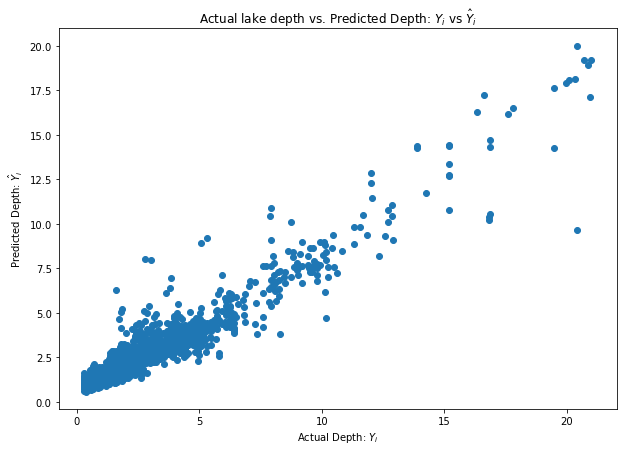

In [5]:
plt.scatter(labels_test.to_array(), predictions.to_array())
plt.xlabel("Actual Depth: $Y_i$")
plt.ylabel("Predicted Depth: $\hat{Y}_i$")
plt.title("Actual lake depth vs. Predicted Depth: $Y_i$ vs $\hat{Y}_i$")
plt.show()

### Random sampling of actual vs predicted data

In [6]:
# Lets look at a random sample of datapoints to see the actual vs predicted depths
import random
for i in range(20):
    random_data_point = random.randint(0, 4635)
    print('Data-point: {:5} Actual: {:20} Predicted: {:20}'.format(random_data_point, labels_test.to_array()[random_data_point],
                                               predictions.to_array()[random_data_point]))

Data-point:  1766 Actual:   1.4459199905395508 Predicted:    1.522056221961975
Data-point:  2921 Actual:   1.9478000402450562 Predicted:   1.9157911539077759
Data-point:  3945 Actual:    1.812000036239624 Predicted:   1.7558488845825195
Data-point:   248 Actual:    0.375234991312027 Predicted:   0.6749032735824585
Data-point:   807 Actual:   2.5411601066589355 Predicted:   2.5940794944763184
Data-point:  1654 Actual:   1.8838399648666382 Predicted:    1.812453269958496
Data-point:  3160 Actual:    5.020830154418945 Predicted:    4.247395992279053
Data-point:   960 Actual:   2.3375399112701416 Predicted:   2.6588261127471924
Data-point:  2572 Actual:    4.454110145568848 Predicted:   3.1644999980926514
Data-point:  2825 Actual:    1.657770037651062 Predicted:    1.749803900718689
Data-point:  2831 Actual:   1.5921499729156494 Predicted:    1.576387882232666
Data-point:  1521 Actual:       3.007080078125 Predicted:   2.5970444679260254
Data-point:  2087 Actual:   1.5236300230026245 Predi

## Feature Importance

Using sklearn's permutation importance


Variables: b35_LC8_07           Importance: -0.04202
Variables: b27_LC8_07           Importance: -0.04872
Variables: b32_LC8_07           Importance: -0.05115
Variables: b16_LC8_07           Importance: -0.05195
Variables: b15_LC8_07           Importance: -0.05198
Variables: b31_LC8_07           Importance: -0.05259
Variables: b6_LC8_075           Importance: -0.0527
Variables: b4_LC8_075           Importance: -0.0575
Variables: b28_LC8_07           Importance: -0.06011
Variables: b22_LC8_07           Importance: -0.06069
Variables: b5_LC8_075           Importance: -0.06349
Variables: b9_LC8_075           Importance: -0.06713
Variables: b11_LC8_07           Importance: -0.06753
Variables: b33_LC8_07           Importance: -0.06938
Variables: b10_LC8_07           Importance: -0.0706
Variables: b14_LC8_07           Importance: -0.07062
Variables: b34_LC8_07           Importance: -0.07547
Variables: b21_LC8_07           Importance: -0.07918
Variables: b30_LC8_07           Importance: -0.08

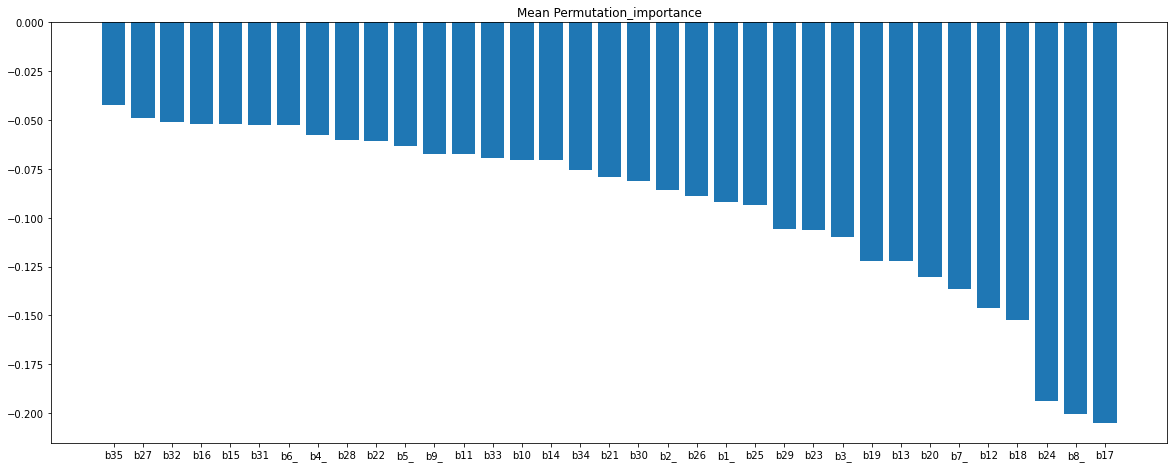

In [7]:
best_rf_model.feature_importances(covariates_train, labels_train, show = True)

## Final Points

* Dask combined with cuDF/cuML is still experimental
* We see significant speedups during training time